### Bandicoot

_bandicoot_ is an open-source python toolbox to analyze mobile phone metadata.

For more information, see: http://bandicoot.mit.edu/

<hr>

In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### Input files

<img src="mini-mockups-01.png" width="80%" style="border: 1px solid #aaa" />

Scheme for ``read_csv`` user records:
> ``interaction,direction,correspondent_id,datetime,call_duration,antenna_id``

Scheme for ``read_orange``:
> ``call_record_type;basic_service;user_msisdn;call_partner_identity;datetime;call_duration;longitude;latitude``

In [2]:
!head -n 5 data/ego.csv

interaction,direction,correspondent_id,datetime,call_duration,antenna_id
text,in,A,2014-03-02 07:13:30,,1
text,in,E,2014-03-02 07:53:30,,1
text,in,E,2014-03-02 08:22:30,,2
text,out,D,2014-03-02 08:34:30,,3


In [3]:
!head -n 5 data/antennas.csv

place_id,latitude,longitude
1,42.366944,-71.083611
2,42.386722,-71.138778
3,42.3604,-71.087374
4,42.353917,-71.105


## Loading a user

In [4]:
import bandicoot as bc
U = bc.read_csv('ego', 'data/', 'data/antennas.csv')

[x] 314 records from 2014-03-02 07:13:30 to 2014-04-14 12:04:37
[x] 7 contacts
[ ] No attributes stored
[x] 27 antennas
[x] Has home
[x] Has texts
[x] Has calls


In [5]:
bc.special.demo.export_antennas(U, 'viz/mobility_view')
bc.special.demo.export_transitions(U, 'viz/mobility_view') 
bc.special.demo.export_timeline(U, 'viz/event_timeline')
bc.special.demo.export_network(U, 'viz/network_view')

In [6]:
from IPython.display import IFrame
IFrame("viz/network_view/index.html", "100%", 400)

In [7]:
from IPython.display import IFrame
IFrame("viz/mobility_view/index.html", "100%", 400)

In [8]:
from IPython.display import IFrame
IFrame("viz/event_timeline/index.html", "100%", 400)

In [9]:
U.records[:3]

[Record(interaction='text', direction='in', correspondent_id='A', datetime=datetime.datetime(2014, 3, 2, 7, 13, 30), call_duration=None, position=Position(antenna=1, location=(42.366944, -71.083611))),
 Record(interaction='text', direction='in', correspondent_id='E', datetime=datetime.datetime(2014, 3, 2, 7, 53, 30), call_duration=None, position=Position(antenna=1, location=(42.366944, -71.083611))),
 Record(interaction='text', direction='in', correspondent_id='E', datetime=datetime.datetime(2014, 3, 2, 8, 22, 30), call_duration=None, position=Position(antenna=2, location=(42.386722, -71.138778)))]

## Individual indicators


1. active_daysmobility point.
2. number_of_contacts
3. number_of_interactions
4. duration_of_calls
5. percent_nocturnal
6. percent_initiated_conversations
7. percent_initiated_interactions
8. response_delay_text
9. response_rate_text
10. entropy_of_contacts
11. balance_of_contacts
12. interactions_per_contact
13. interevent_time

In [10]:
bc.individual.entropy_of_contacts(U, groupby=None)

{'allweek': {'allday': {'call': 1.8626732085630935,
   'text': 1.8462551114653172}}}

In [11]:
bc.individual.percent_initiated_conversations(U, groupby=None)

{'allweek': {'allday': {'callandtext': 0.3080357142857143}}}

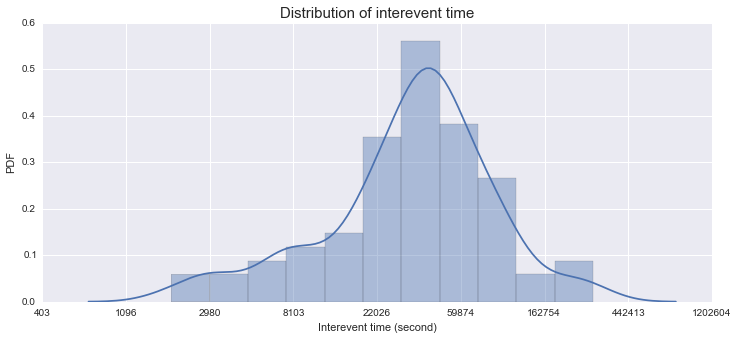

In [12]:
interevent = bc.individual.interevent_time(U, groupby=None, summary=None)

f, axes = plt.subplots(figsize=(12, 5))
sns.distplot(np.log(interevent['allweek']['allday']['call']),  norm_hist=True)
title('Distribution of interevent time', fontsize=15)
plt.xlabel('Interevent time (second)')
plt.ylabel('PDF')
_ = plt.xticks(plt.xticks()[0], [int(np.exp(i)) for i in plt.xticks()[0]])

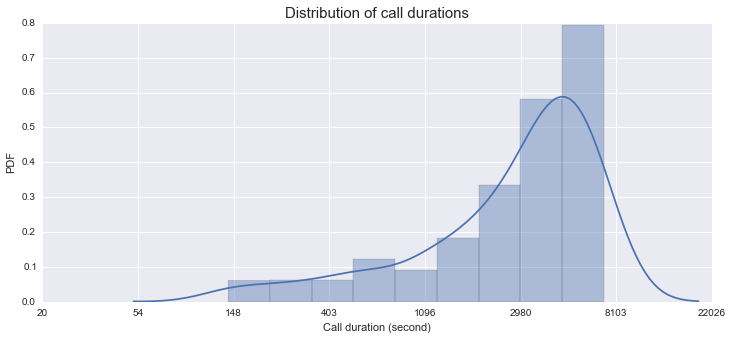

In [13]:
call_durations = bc.individual.call_duration(U, groupby=None, summary=None)

f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(np.log(call_durations['allweek']['allday']['call']), kde=True)
title('Distribution of call durations', fontsize=15)
plt.xlabel('Call duration (second)')
plt.ylabel('PDF')
_ = plt.xticks(plt.xticks()[0], [int(np.exp(i)) for i in plt.xticks()[0]])

## Spatial indicators

1. number_of_antennas
2. entropy_of_antennas
3. percent_at_home
4. radius_of_gyration

In [14]:
print bc.spatial.number_of_antennas(U, groupby=None)

{'allweek': {'allday': 10}}


In [15]:
bc.spatial.radius_of_gyration(U, groupby=None)

{'allweek': {'allday': 2.5809796846399546}}

In [16]:
print "Home:", U.home
print "Percent at home: {0:.0f}%".format(100 * bc.spatial.percent_at_home(U, groupby=None)['allweek']['allday'])

Home: Position(antenna=1, location=(42.366944, -71.083611))
Percent at home: 47%


## Weekly aggregation

By default, _bandicoot_ computes the indicators on a weekly basis and returns the mean over all the weeks available and its standard error (sem) in a nested dictionary.

The ``groupby='week'`` or ``groupby=None`` keyword controls the aggregation.

<img src="mini-mockups-02.png" width="80%" style="border: 1px solid #aaa" />

In [17]:
bc.individual.active_days(U, groupby=False)

{'allweek': {'allday': {'callandtext': {'mean': 5.5,
    'std': 2.598076211353316}}}}

In [18]:
bc.individual.active_days(U)

{'allweek': {'allday': {'callandtext': {'mean': 5.5,
    'std': 2.598076211353316}}}}

In [19]:
bc.individual.active_days(U, summary=None)

{'allweek': {'allday': {'callandtext': [1, 7, 7, 7, 7, 7, 7, 1]}}}

## Summary

Some indicators such as _active_days_ returns one number. Others, such as _duration_of_calls_ returns a distribution.

The summary keyword can take three values:

 - `default`: to return mean and sem;
 - `extended` for the second type of indicators, to return mean, sem, median, skewness and std of the distribution;
 - `None`: to return the full distribution.

In [20]:
bc.individual.call_duration(U, summary='extended', groupby=None)

{'allweek': {'allday': {'call': {'kurtosis': 1.8729008836491094,
    'max': 7123.0,
    'mean': 3557.2933333333335,
    'median': 3552.0,
    'min': 140.0,
    'skewness': -0.01195616625912045,
    'std': 2067.863501448348}}}}

In [21]:
print bc.individual.call_duration(U, summary=None, groupby=None)

{'allweek': {'allday': {'call': [140, 154, 231, 267, 374, 403, 539, 594, 620, 706, 969, 1086, 1099, 1273, 1309, 1330, 1355, 1853, 1890, 1927, 1937, 1999, 2072, 2109, 2258, 2456, 2626, 2726, 2854, 2871, 3210, 3286, 3404, 3435, 3454, 3503, 3531, 3552, 3609, 3668, 3782, 4002, 4146, 4154, 4202, 4227, 4240, 4451, 4472, 4666, 4689, 4832, 4877, 4929, 5096, 5142, 5184, 5359, 5413, 5658, 5689, 5728, 5752, 5804, 6233, 6392, 6429, 6539, 6541, 6674, 6682, 6891, 7038, 7082, 7123]}}}


## Exporting indicators

In [22]:
bc.utils.all(U, groupby=None)

{
    "name": "ego", 
    "reporting": {
        "antennas_path": "data/antennas.csv", 
        "attributes_path": None, 
        "version": "0.3.0", 
        "groupby": None, 
        "split_week": false, 
        "split_day": false, 
        "start_time": "2014-03-02 07:13:30", 
        "end_time": "2014-04-14 12:04:37", 
        "night_start": "19:00:00", 
        "night_end": "07:00:00", 
        "weekend": [
            6, 
            7
        ], 
        "bins": 1, 
        "has_call": true, 
        "has_text": true, 
        "has_home": true, 
        "percent_records_missing_location": 0.0, 
        "antennas_missing_locations": 0, 
        "percent_outofnetwork_calls": 0.96, 
        "percent_outofnetwork_texts": 0.9372384937238494, 
        "percent_outofnetwork_contacts": 0.8571428571428571, 
        "percent_outofnetwork_call_durations": 0.9395982713448802, 
        "number_of_records": 314, 
        "ignored_records": {
            "all": 0, 
            "interaction": 

In [23]:
bc.io.to_csv([bc.utils.all(U, groupby=None)], 'demo_export_user.csv')
bc.io.to_json([bc.utils.all(U, groupby=None)], 'demo_export_user.json')

Successfully exported 1 object(s) to demo_export_user.csv
Successfully exported 1 object(s) to demo_export_user.json


In [24]:
!head -n 5 demo_export_user.csv